# Рекомендация тарифов

Необходимо на основе имеющихся данных предложить клиенту тарифы

В данном проекте мной были использованы несколько моделей машинного обучения, для создания рекомендательной системы для клиентов

`сalls` — количество звонков\
`minutes` — суммарная длительность звонков в минутах\
`messages` — количество sms-сообщений\
`mb_used` — израсходованный интернет-трафик в Мб\
`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

**import package**

In [1]:
from io import BytesIO
import requests
from IPython.display import HTML
from tqdm.notebook import tqdm_notebook as tqdmn

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

**import file**

In [2]:
try:
    data_rate = pd.read_csv('../datasets/users_behavior (1).csv')
except:
    pass

**format_function**

In [3]:
def print_hr_line():
    display(HTML('<hr align="left" width="500" size="4" color="#dddddd" />'))

In [4]:
# Добавляем новые стили в проект
style = """<style>
div.red_line {height:30px; width:560px; border-left:2px solid #cc0030; padding-left:10px;}
div.blue_line {height:30px; width:560px; border-left:7px solid #0A58E5; padding-left:10px;}
div.text_comment {font-family: verdana;font-size: 100%;background-color: #C7D5EE;border-color: black;border-style: solid;padding: 5px}
div.text_comment_student {font-family: verdana;font-size: 100%;background-color: #32C462;border-color: black;border-style: solid;padding: 5px}

div.text_comment_new_year {

   text-transform: uppercase;
  background-image: linear-gradient(
    -225deg,
    #231557 0%,
    #44107a 29%,
    #AEC226 50%,
    #ff1361 67%,
    #fff800 100%
  );
  background-size: auto auto;
  background-clip: border-box;
  background-size: 200% auto;
  color: #fff;
  background-clip: text;
  text-fill-color: transparent;
  -webkit-background-clip: text;
  -webkit-text-fill-color: transparent;
  animation: textclip 2s linear infinite;
  display: inline-block;
      font-size: 15px;
}

@keyframes textclip {
  to {
    background-position: 100% center;
  }
}
</style>"""
HTML(style)

<div class="blue_line">

## Исследование данных

<div class="red_line">
    
### Общая информация

In [5]:
display(data_rate.head())
print_hr_line()
display(data_rate.info())
print_hr_line()
display(data_rate.describe())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


<div class="text_comment">
    
Исходя из текущих данных мы видим
- данные выгрузились корректно
- максимальные значения звонков и сообщение одинаково. Скорее всего данные были предобработаны либо существует лимит на тарифе ультра
- количество мегабайт также не более 50 тыс, скорее всего существует ограничение в 50 гб
- данная задача является задачей классификации

<div class="red_line">
    
### Проверка данных

Проверка на дубликаты

In [6]:
data_rate.duplicated().sum()

0

Проверка на пустые значения

In [7]:
data_rate.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Проверка на выбросы

*Исходя из максимальных значений можно убедиться, что серьезных отклонений от нормы нету и все значения адекватные.\
Таким образом мы проверили, что данные действительно предобработаны*

<div class="text_comment">
Данные уже были ранее предобработаны, так что в преообработке нету необходимости

<div class="red_line">
    
### Корреляция

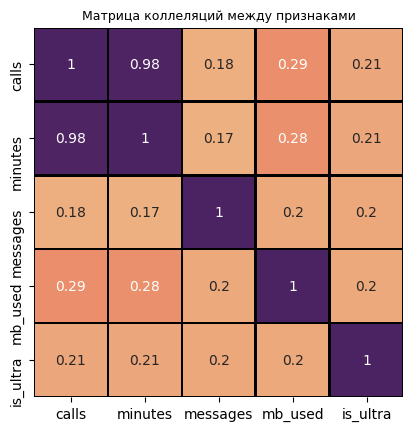

In [8]:
sns.heatmap(data_rate.corr(),annot = True,cmap = 'flare',
            linecolor = 'black',linewidths=1, cbar=False,square = True)

plt.title('Матрица коллеляций между признаками',fontdict= {'fontsize':9})
plt.show()

Мы видим, что целевой признак не коррелирует ни с одним из признаков\
При этом стоит отметить высокую корреляцию между минутами и звонками

Проверка корреляции между минутами и звонками

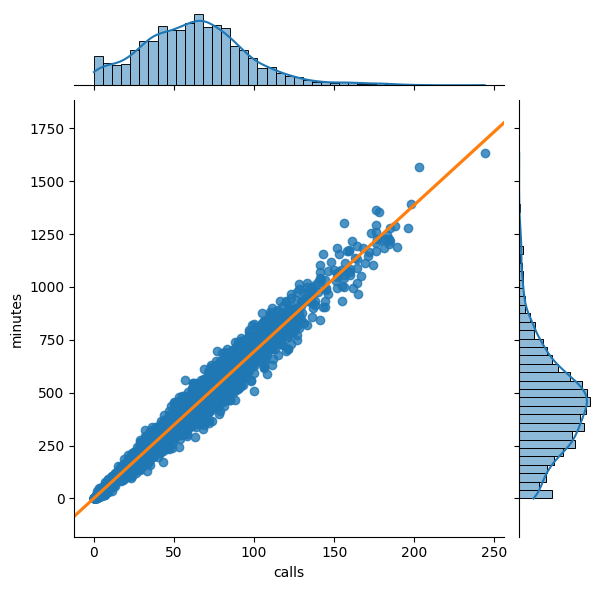

In [9]:
sns.jointplot(data = data_rate, x = 'calls', y = 'minutes',
          line_kws={"color": "C1"}, kind="reg", truncate=False)

Мы видим почти прямую зависимость и схожее распределение, скорее всего в дальнейшем в датасете можно будет попробовать удалить один из признаков,\
так как они могут оказывать практически одинаковое влияние на модель

<div class="text_comment">
Между количеством звонком и минут имеется практически прямая корреляция, которая в дальнейшем может повлиять на точность модели

<div class="red_line">
    
### Распределения между данными

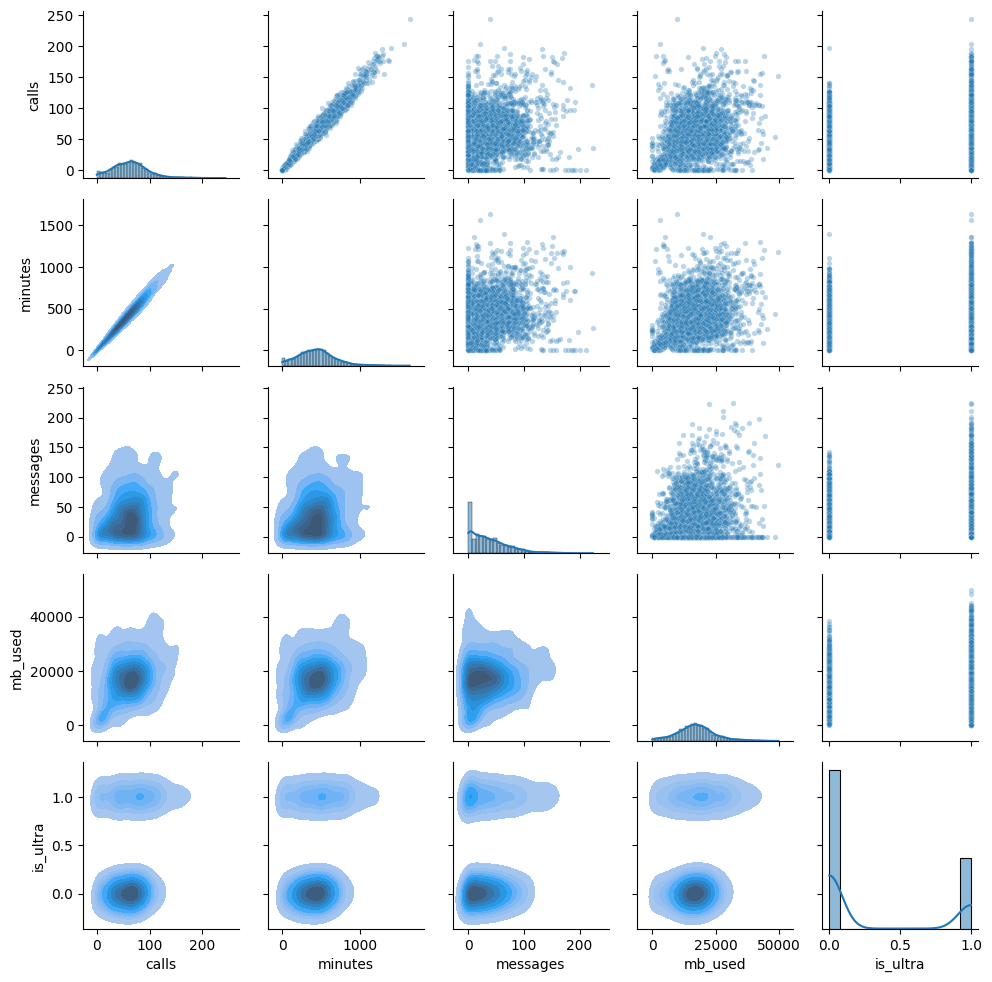

In [10]:
g = sns.PairGrid(data_rate, height=2)
g.map_upper(sns.scatterplot,s = 15,alpha = 0.3)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

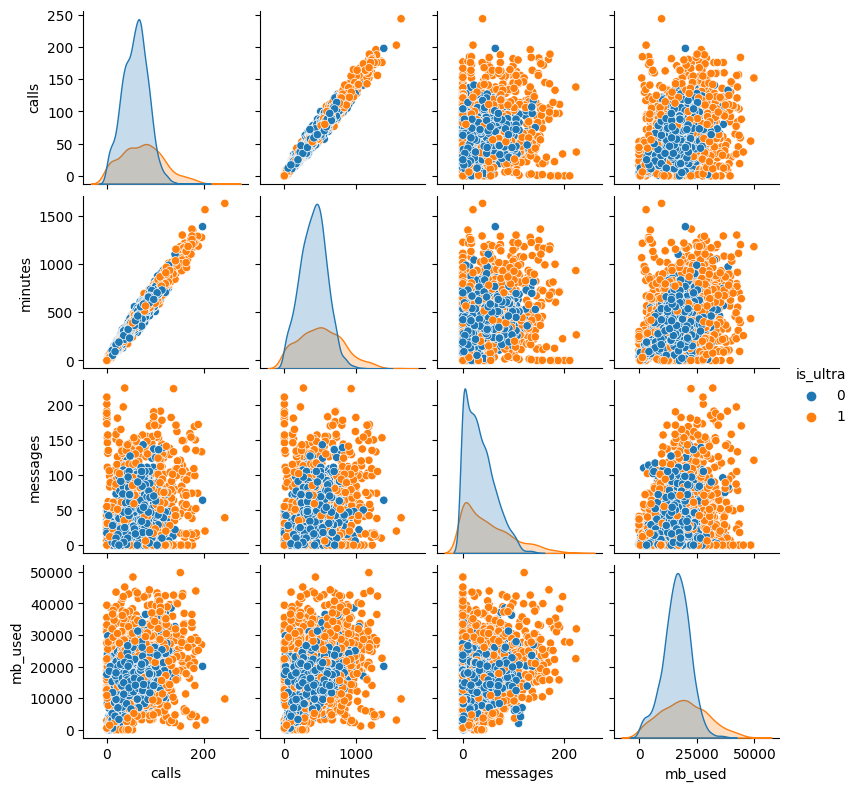

In [11]:
sns.pairplot(data_rate, hue = 'is_ultra', height=2);

<div class="text_comment">
Исходя из текущего графика можно сделать несколько выводов

- Целевой признак `is_ultra` распределен несимместрично
- `calls`, `minutes`, `mb_used` похожи на нормальное распределение
- `messages` - напоминает распределение бернулли
- Те, кто пользуется тарифом `is_iltra` имеют больший размах в значениях параметров

<div class="red_line">
    
### Введение нового признака

Введем новый признак - среднее время звонка

In [12]:
data_rate['time_call'] = data_rate['minutes'] / data_rate['calls'] 
data_rate['time_call'] = data_rate['time_call'].fillna(0)

In [13]:
data_rate.corr()['time_call']

calls        0.148412
minutes      0.249895
messages    -0.054004
mb_used     -0.028443
is_ultra    -0.087717
time_call    1.000000
Name: time_call, dtype: float64

<div class="text_comment">
Введен новый показатель - среднее время звонка, который не коррелирует с другими показателями


<div class="blue_line">
    
## Разбиение данных на выборки

In [14]:
y = data_rate.is_ultra
X = data_rate.drop(['is_ultra'], axis=1)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify = y)

Итого мы получили 20% выборки - тест.\
Чтобы в дальнейшем разбить выборку на обучающую и валидационную\
необходимо будет взять 25 процентов от оставшейся выборке, чтобы в валидационной\
осталось 20 процентов

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=0, 
    stratify = y_train_full)

<div class="blue_line">

## Предобработка

В данном задании имеется необходимость проверить несколько моделей, поэтому\
будут использоваться Pipeline

В preprocessor необходимо только нормализовать данные

In [16]:
all_cols = ['calls','minutes','messages','mb_used','time_call']
base_cols = ['calls','minutes','messages','mb_used']
cols_not_corr_1 = ['calls','messages','mb_used','time_call']
cols_not_corr_2 = ['minutes','messages','mb_used','time_call']


Создадим функцию в которую мы будем передавать модель, а она будет нам возвращать pipeline

In [17]:
def get_model_pipe(model,cols = all_cols):
    
    numeric_transformer = StandardScaler()
    # по умолчанию установлено, что столбцы не участвующие в трансформации
    # удаляются. Так что дополнительный selector здесь не нужен
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cols)]
    )
    
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                             ])
    return my_pipeline

Также создадим функцию для первичного обзора модели.\
Данная функция будет обучать модель при помощи GridSearch\
и печатать значения best_score

In [18]:
def get_model_accuracy(model_pipe, params = {},print_score = True):
    """Передаем необученную модель
    возвращает обученную модель и печатает best_score"""
    params = {}
    model_func = GridSearchCV(estimator = model_pipe,param_grid=params, cv=5)
    model_func.fit(X_train_full,y_train_full)
    
    if print_score == True:
        print("Модель best accuracy train",model_func.best_score_)
    
    return model_func

<div class="blue_line">

## Исследуемые модели

<div class="red_line">

### Логистическая регрессия

Стандартные настройки логистической регрессии

In [19]:
model_logistic_main = get_model_pipe(LogisticRegression(max_iter=1000,random_state=12345))
# Обучаем модель
get_model_accuracy(model_logistic_main);

Модель best accuracy train 0.7549582562049035


Мы видим, что на обучающей выборке не имеем целевого accuracy, а на валидационной значение даже выше

Проверим будет ли различаться accuracy, если будут использованы разные колонки

In [20]:
# в данную функцию мы передаем разные колонки и проверяем метрики
def get_logistic_with_cols(cols):
    pipe_logistic_ = get_model_pipe(LogisticRegression(max_iter=1000),cols = cols)
    get_model_accuracy(pipe_logistic_)
    

print('Все колонки, accuracy:')
get_logistic_with_cols(all_cols)
print('Изначальные колонки, accuracy:')
get_logistic_with_cols(base_cols)
print('Колонки без кол-ва минут, accuracy:')
get_logistic_with_cols(cols_not_corr_1)
print('Колонки без кол-ва звонков, accuracy:')
get_logistic_with_cols(cols_not_corr_2)


Все колонки, accuracy:
Модель best accuracy train 0.7549582562049035
Изначальные колонки, accuracy:
Модель best accuracy train 0.7460095954062937
Колонки без кол-ва минут, accuracy:
Модель best accuracy train 0.7444539307166333
Колонки без кол-ва звонков, accuracy:
Модель best accuracy train 0.7448415246873937


**Достаточно серьезное отклонение. Мы видим, логистическая гегрессия
показала себя лучше всего на всех колонках**

In [21]:
best_model_logistic = get_model_accuracy(LogisticRegression(max_iter=1000),all_cols)

Модель best accuracy train 0.7518491934569906


Регуляризация

Попробуем проверить как модель поведет cебя с регуляризацией

In [22]:
list_reg = list(np.linspace(0,1,350))[1:]
list_res = []
list_res_1 = []

# мы передаем сразу в функцию модель, идет кросс валидация и обучение модели
# в модель передаем коэффициент регуляризации, а затем best score передаем в
# список
for reg_val in list_reg:
    pipe_logistic_reg = get_model_accuracy(
        LogisticRegression(max_iter=1000,penalty='l2', C=reg_val),print_score = False)
    # Обучаем модель
    list_res.append(pipe_logistic_reg.best_score_)
    if pipe_logistic_reg.best_score_ > 0.7525:
        print(reg_val)
    

0.022922636103151862


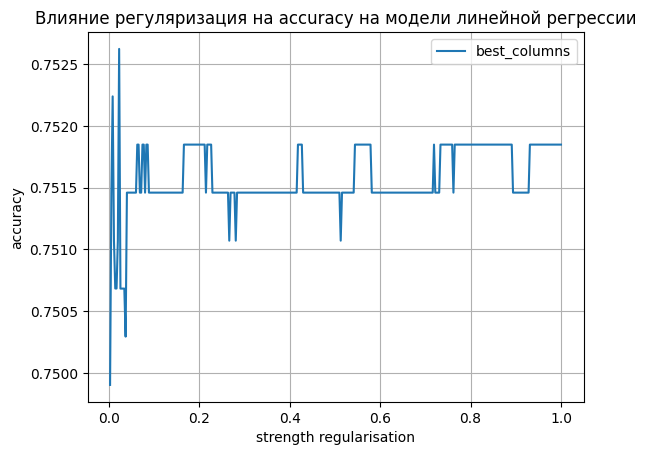

In [23]:
sns.lineplot(x = list_reg, y = list_res,label='best_columns')

plt.title("Влияние регуляризация на accuracy на модели линейной регрессии")
plt.ylabel("accuracy")
plt.xlabel("strength regularisation")
plt.grid();

Мы видим, что можем немного улучшить результаты при регуляризации 0.4

In [24]:
best_model_logistic = get_model_accuracy(
    LogisticRegression(max_iter=1000, penalty='l2', C=0.02292),all_cols)

Модель best accuracy train 0.7526243813985116


In [25]:
best_model_logistic.best_score_

0.7526243813985116

In [26]:
best_model_logistic.score(X_test,y_test)

0.744945567651633

<div class="text_comment">
    
Итого лучший показатель  pipe_logistic с колонками без кол-ва звонков и без штрафа за переобучение \
accuracy около `0.75`

<div class="red_line">

### Дерево решений

In [27]:
model_tree_main = get_model_pipe(DecisionTreeClassifier(random_state = 12345))

In [28]:
model_tree_grid = get_model_accuracy(model_tree_main);

Модель best accuracy train 0.7273453968493824


In [29]:
model_tree_main.fit(X_train,y_train);

Без настроенных гиперпараметров модель сталкивается с переобучением \
Из-за этого возникает низкая точность


Визуализируем дерево решений для лучшего понимания процессов

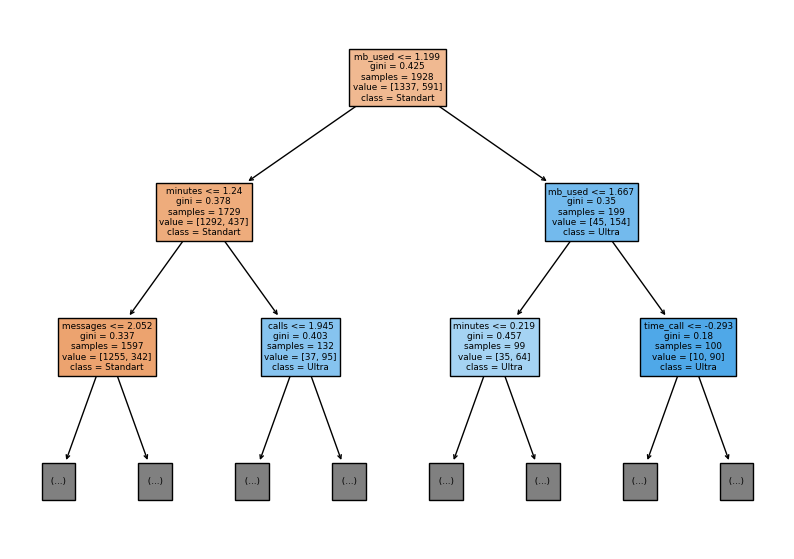

In [30]:
plt.figure(figsize =(10,7))
plot_tree(model_tree_main[1], feature_names=all_cols, max_depth=2, 
          filled=True, class_names= ['Standart','Ultra']);

Далее необходимо подобрать гиперпараметры

In [31]:
param_grid_tree_1  = {
    'model__max_depth' :range(1,100)
}

In [32]:
model_tree_best = GridSearchCV(get_model_pipe(DecisionTreeClassifier(random_state = 12345)), 
                               param_grid_tree_1, cv=5)
model_tree_best.fit(X_train_full,y_train_full);

In [33]:
model_tree_best.best_params_

{'model__max_depth': 8}

In [34]:
model_tree_best.best_score_

0.7926938914283556

accuracy около `0.79`, что является лучшим показателем, чем логистическая регрессия

In [35]:
def return_grid_search_plot(model_tree_best):
    data_params = pd.DataFrame(model_tree_best.cv_results_['params'])
    data_params['score'] = model_tree_best.cv_results_['mean_test_score']
    sns.lineplot(data = data_params, x = 'model__max_depth', 
             y = 'score' )
    plt.show()

Построим график, чтобы посмотреть, как обучалась модель и где возникли проблемы

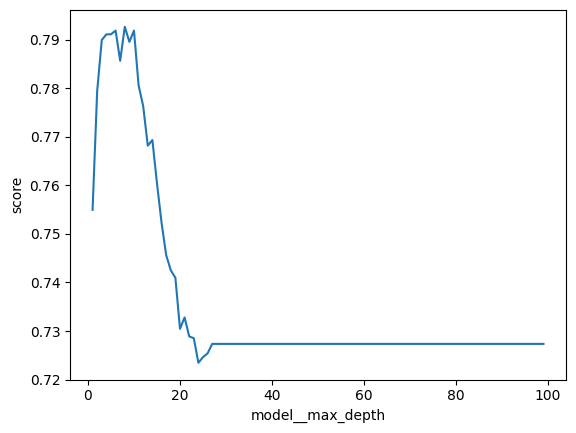

In [36]:
return_grid_search_plot(model_tree_best)

Видно, что после 25 деревьев прироста не было, значит это будет верхний предел обучения решающего дерева

<div class="text_comment">
    
Итого лучший показатель  pipe_tree с max_depth = 8 \
accuracy около `0.79`

<div class="red_line">

### Случайный лес

Данная модель должна обладать большей точностью, чем предыдущие модели

In [37]:
#строим модель через Pipeline. Пока не передеем гиперпараметры
model_tree_random = get_model_pipe(RandomForestClassifier(random_state = 12345))


# Обучаем модель передав ей функцию где сразу есть кросс-валидация
model_tree_random = get_model_accuracy(model_tree_random);

Модель best accuracy train 0.7996924936723205


In [38]:
param_grid_random  = {
    'model__n_estimators': range(1,100,10), 
    'model__max_depth' : range(1,30,5)
}

In [39]:
model_tree_random_best = get_model_pipe(RandomForestClassifier(random_state = 12345))

model_tree_random_best = GridSearchCV(model_tree_random_best, param_grid_random, cv=5)
model_tree_random_best.fit(X_train_full,y_train_full);

In [40]:
model_tree_random_best.best_params_

{'model__max_depth': 11, 'model__n_estimators': 71}

In [41]:
model_tree_random_best.best_score_

0.8039666049639227

In [42]:
def return_grid_search_plot(model_grid):
    data_params = pd.DataFrame(model_grid.cv_results_['params'])
    data_params['score'] = model_grid.cv_results_['mean_test_score']
    sns.lineplot(data = data_params, x = 'model__n_estimators', 
             y = 'score' , hue = 'model__max_depth')
    plt.show()

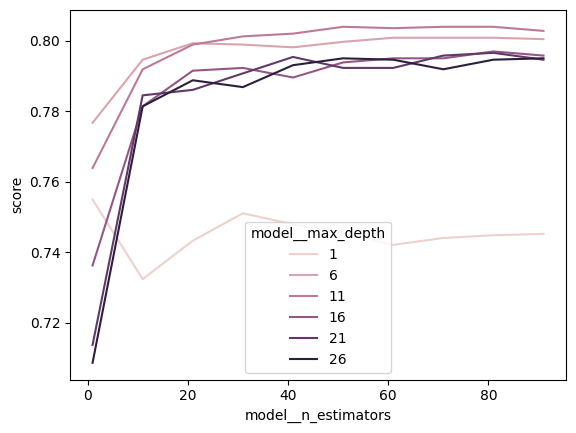

In [43]:
return_grid_search_plot(model_tree_random_best)

Проверим теперь небольших значениях

In [44]:
param_grid_random_1  = {
    'model__n_estimators': range(1,20,1), 
    'model__max_depth' : range(1,20,1)
}

In [45]:
model_tree_random_best = get_model_pipe(RandomForestClassifier(random_state = 12345))

#долго обучается
model_tree_random_best = GridSearchCV(model_tree_random_best, param_grid_random_1, cv=5)
model_tree_random_best.fit(X_train_full,y_train_full);

In [46]:
model_tree_random_best.best_score_

0.8039681160515281

In [47]:
model_tree_random_best.best_params_

{'model__max_depth': 8, 'model__n_estimators': 13}

<div class="text_comment">

Ожидаемо по точности модели лучше оказался случайный лес c accuracy `0.80`

<div class="red_line">


### AdaBoosting

Рассмотрим бустинговый алгоритм в sklearn

In [48]:
# создаем pipeline
model_tree_ada_boost = get_model_pipe(AdaBoostClassifier(random_state = 12345))


# передаем pipeline в функцию, которая делает кросс валидацию
# и обучает модель на train данных
model_tree_ada_boost = get_model_accuracy(model_tree_ada_boost);

Модель best accuracy train 0.7954161157493106


Видно что уже на этапе обучения данный алгоритм показывает схожие результаты как со случайным лесом\
Попробуем настроить гиперпараметры

In [49]:
param_grid_boost = {  
                    "model__n_estimators": range(1,20)
             }

In [50]:
model_tree_ada_boost_2 = get_model_pipe(AdaBoostClassifier(random_state = 12345))


model_tree_ada_boost_2= GridSearchCV(model_tree_ada_boost_2, param_grid_boost, cv=5)
model_tree_ada_boost_2.fit(X_train_full,y_train_full);

In [51]:
model_tree_ada_boost_2.best_params_

{'model__n_estimators': 18}

In [52]:
model_tree_ada_boost_2.best_score_

0.797362396584942

<div class="text_comment">

Мы видим, что такой простой бустинговый алгоритм, основанный на предсказании ошибки \
показывает себя на уровне Random Forest

Попробуем улучшить Ada Boosting передав ему случайный лес. По умолчанию данному алгоритму передается дерево решений

In [53]:
RFC = RandomForestClassifier(random_state = 12345,
                            max_depth=8,
                            n_estimators = 13)

pipe_tree_ada_boost_modif = get_model_pipe(AdaBoostClassifier(random_state = 12345,
                                                              base_estimator=RFC,n_estimators=8))

pipe_tree_ada_boost_modif = get_model_accuracy(pipe_tree_ada_boost_modif)

Модель best accuracy train 0.7876302368629821


Попробуем подобрать лучшие параметры, здесь скорее всего есть переобучение

In [54]:
score_total = 0
for depth in tqdmn(range(1,15)):
    for est in range(1,15):
        for est_2 in range(1,15):
            RFC = RandomForestClassifier(random_state = 12345,
                                        max_depth=depth,
                                        n_estimators = est)

            pipe_tree_ada_boost_modif = get_model_pipe(AdaBoostClassifier(random_state = 12345,n_estimators=est_2,
                                                                         base_estimator=RFC))
            score = pipe_tree_ada_boost_modif.fit(X_train,y_train)
            score = pipe_tree_ada_boost_modif.score(X_valid,y_valid)
            if score > score_total:
                score_total = score
                print(score,depth,est,est_2)

  0%|          | 0/14 [00:00<?, ?it/s]

0.7651632970451011 1 1 1
0.7947122861586314 1 1 2
0.7962674961119751 1 1 14
0.8133748055987559 1 2 4
0.8149300155520995 1 5 8
0.8164852255054432 2 3 3
0.8180404354587869 2 3 4
0.8195956454121306 2 6 5
0.8242612752721618 4 6 2


Итого модифицировав adaboost удалось выйти на неплохие показатели на валидационной выборке

In [55]:
RFC = RandomForestClassifier(random_state = 12345,
                                    max_depth=4 ,
                                    n_estimators = 6)

pipe_tree_ada_boost_modif = get_model_pipe(AdaBoostClassifier(random_state = 12345,base_estimator=RFC
                                                              ,n_estimators=2
                                                             )
                                          )

pipe_tree_ada_boost_modif = get_model_accuracy(pipe_tree_ada_boost_modif);

Модель best accuracy train 0.8004676816138415


## Проверка моделей на тестовой выборке

In [56]:
pipe_tree_ada_boost_modif.score(X_test,y_test)

0.8087091757387247

In [57]:
model_tree_random_best.score(X_test,y_test)

0.8211508553654744

<div class="text_comment">

Итого 
- на тестовой выборке accuracy Random Forest получился `0.82`
- на тестовой выборке accuracy модицифированный Adaptive Boost получился `0.81`

Рандомный лес
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       446
           1       0.81      0.55      0.65       197

    accuracy                           0.82       643
   macro avg       0.82      0.74      0.77       643
weighted avg       0.82      0.82      0.81       643



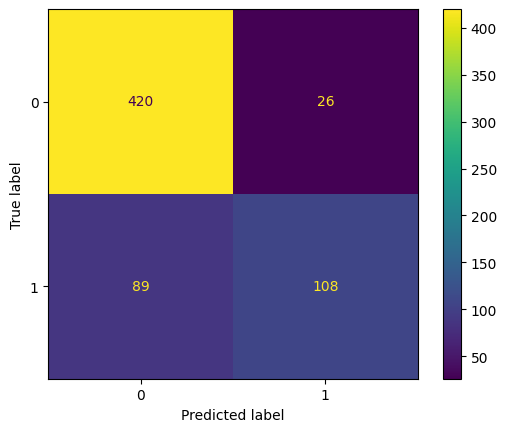

In [58]:
print('Рандомный лес')
y_predict = model_tree_random_best.predict(X_test)
report = classification_report(y_test, y_predict)
print(report)
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

## Проверка модели на адекватность

Для проверки используем DummyClassifier

In [59]:
strat = ["most_frequent", "prior","stratified", "constant", "uniform"]
for s in strat:
    if s == "constant":
        dummy_clf = DummyClassifier(strategy=s,random_state=12345,constant=0)
    else:
        dummy_clf = DummyClassifier(strategy=s,random_state=12345)
    dummy_clf.fit(X_train,y_train)
    print(s)
    print(dummy_clf.score(X_valid,y_valid))
    print("----------------------xxxxxxx----------------------")

most_frequent
0.6936236391912908
----------------------xxxxxxx----------------------
prior
0.6936236391912908
----------------------xxxxxxx----------------------
stratified
0.6003110419906688
----------------------xxxxxxx----------------------
constant
0.6936236391912908
----------------------xxxxxxx----------------------
uniform
0.5318818040435459
----------------------xxxxxxx----------------------


## ИТОГО 🎄 
    
- Было проведен краткий анализ
    - Выявлены зависимости между переменными
    - Построен новый признак (время звонка, который улучшил значение метрик на 0.1)
- В данной работе была использована Кросс-валидация и Pipeline для более лаконичного кода
- Было обучено четыре модели
    - Логистическая регрессия
    - Дерево решений
    - Случайный лес
    - Адаптивный бустинг
- Среди четырех моделей лучше себя показал случайный лес. На тестовой выборке accuracy получился `0.82`
- Была проведена проверка модели на адекватность, и ни одна из Dummy моделей не смогла показать accyracy выше `0.7`
- Дополнительно были подсчитаны precision и recall